In [1]:
DATASET_PATH = "./dataset/thai_house_resized_64_aug"
PROJECT_PATH = "dcgan_thaihouse64_aug_50epochs"

# 1. Discriminator and Generator implementation from DCGAN paper

In [2]:
"""
Discriminator and Generator implementation from DCGAN paper
"""

import torch
import torch.nn as nn


class Discriminator(nn.Module):

    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # Input: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),  # 32x32
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d*2, 4, 2, 1),  # 16x16
            self._block(features_d*2, features_d*4, 4, 2, 1),  # 8x8
            self._block(features_d*4, features_d*8, 4, 2, 1),  # 4x4
            nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2,
                      padding=0),  # Single-channel Output 1x1
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):

    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            # Input: N x z_dim x 1 x 1
            self._block(z_dim, features_g*16, 4, 1, 0),  # N x f_g*16 x 4 x 4
            self._block(features_g*16, features_g*8, 4, 2, 1),  # 8x8
            self._block(features_g*8, features_g*4, 4, 2, 1),  # 16x16
            self._block(features_g*4, features_g*2, 4, 2, 1),  # 32x32
            nn.ConvTranspose2d(
                features_g*2,
                channels_img,
                kernel_size=4,
                stride=2,
                padding=1),
            nn.Tanh(),  # [-1, 1]
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.gen(x)


def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)


In [3]:
"""
Training of DCGAN network on MNIST dataset with Discriminator
and Generator imported from models.py
"""

import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
#from model import Discriminator, Generator, initialize_weights

# Hyperparameters etc.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 2e-4  # could also use two lrs, one for gen and one for disc
BATCH_SIZE = 32
IMAGE_SIZE = 64
CHANNELS_IMG = 3
NOISE_DIM = 100
NUM_EPOCHS = 50
FEATURES_DISC = 128
FEATURES_GEN = 128

transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)



dataset = datasets.ImageFolder(root=DATASET_PATH, transform=transforms)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"tensorboard_logs/"+PROJECT_PATH+"/logs/real")
writer_fake = SummaryWriter(f"tensorboard_logs/"+PROJECT_PATH+"/logs/fake")
step = 0

gen.train()
disc.train()



Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(1024, 1, kernel_size=(4, 4), stride=(2, 2))
    (6): Sigmoid()
  )
)

# 2. Train

In [12]:
log_loss_disc =[]
log_loss_gen=[]

for epoch in range(NUM_EPOCHS):
    # Target labels not needed! <3 unsupervised
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)
        noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
        fake = gen(noise)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
                  Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(
                    real[:32], normalize=True
                )
                img_grid_fake = torchvision.utils.make_grid(
                    fake[:32], normalize=True
                )

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1
            
    torch.save(gen, "./saved_models/"+PROJECT_PATH+"/gen_@"+str(epoch))
    torch.save(disc, "./saved_models/"+PROJECT_PATH+"/disc_@"+str(epoch))
    log_loss_disc.append(loss_disc)
    log_loss_gen.append(loss_gen)

Epoch [0/50] Batch 0/313                   Loss D: 0.6901, loss G: 0.9729
Epoch [0/50] Batch 100/313                   Loss D: 0.3415, loss G: 4.2493
Epoch [0/50] Batch 200/313                   Loss D: 0.3741, loss G: 3.5984
Epoch [0/50] Batch 300/313                   Loss D: 0.5349, loss G: 2.7359
Epoch [1/50] Batch 0/313                   Loss D: 0.3429, loss G: 3.2770
Epoch [1/50] Batch 100/313                   Loss D: 0.3831, loss G: 2.8923
Epoch [1/50] Batch 200/313                   Loss D: 0.4607, loss G: 2.5803
Epoch [1/50] Batch 300/313                   Loss D: 0.4422, loss G: 3.0726
Epoch [2/50] Batch 0/313                   Loss D: 0.5488, loss G: 1.9174
Epoch [2/50] Batch 100/313                   Loss D: 0.4554, loss G: 2.1331
Epoch [2/50] Batch 200/313                   Loss D: 0.3219, loss G: 2.1570
Epoch [2/50] Batch 300/313                   Loss D: 0.5140, loss G: 1.7779
Epoch [3/50] Batch 0/313                   Loss D: 0.4462, loss G: 2.0690
Epoch [3/50] Batch 1

Epoch [27/50] Batch 0/313                   Loss D: 0.0305, loss G: 5.3546
Epoch [27/50] Batch 100/313                   Loss D: 0.0111, loss G: 8.6467
Epoch [27/50] Batch 200/313                   Loss D: 0.0550, loss G: 8.3946
Epoch [27/50] Batch 300/313                   Loss D: 0.0434, loss G: 5.9725
Epoch [28/50] Batch 0/313                   Loss D: 1.7359, loss G: 18.1147
Epoch [28/50] Batch 100/313                   Loss D: 0.1197, loss G: 6.8272
Epoch [28/50] Batch 200/313                   Loss D: 0.0445, loss G: 4.7879
Epoch [28/50] Batch 300/313                   Loss D: 0.1563, loss G: 2.4906
Epoch [29/50] Batch 0/313                   Loss D: 0.0273, loss G: 6.6431
Epoch [29/50] Batch 100/313                   Loss D: 0.2063, loss G: 3.2100
Epoch [29/50] Batch 200/313                   Loss D: 0.0191, loss G: 4.9458
Epoch [29/50] Batch 300/313                   Loss D: 0.0507, loss G: 6.5879
Epoch [30/50] Batch 0/313                   Loss D: 0.0275, loss G: 6.3775
Epoch 

# 3. Load saved models

### 3.1 Load generator

In [4]:
model = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)

In [5]:
%ls "saved_models/dcgan_thaihouse64_aug_50epochs"

 Volume in drive C is OS
 Volume Serial Number is BE10-F9C3

 Directory of C:\Users\siraw\Desktop\thaihouse dcgan final\saved_models\dcgan_thaihouse64_aug_50epochs

19-Jun-21  10:04 PM    <DIR>          .
19-Jun-21  10:04 PM    <DIR>          ..
19-Jun-21  07:28 PM       189,391,039 gen_@27
               1 File(s)    189,391,039 bytes
               2 Dir(s)  78,488,121,344 bytes free


In [23]:
model = torch.load("./saved_models/"+PROJECT_PATH+"/gen_@27") # Best generator @epoch27
model.train()

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 2048, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): ConvTranspose2d(256, 

# 4. Model inference

### 4.0 Utility function

In [24]:
import matplotlib.pyplot as plt
import cv2
from skimage import img_as_ubyte
import os

In [25]:
def tensor_to_img(tensor, model):
    # Feed into model and reshape to (3, H, W)
    img  = model(tensor).squeeze(0).permute(1,2,0).detach().cpu().numpy()
    
    # Convert to 0-255
    img = img_as_ubyte(img)
    return img

In [26]:
def generate_noise(n):
    return torch.randn(1,n,1,1).to(device)

### 4.1 Just one

In [192]:
import matplotlib.pyplot as plt
import cv2

from skimage import img_as_ubyte
import os

In [190]:
# Generate noise of size 100
one_noise = generate_noise(100)

# Feed into model and reshape to (3, H, W)
one_img = tensor_to_img(one_noise,  model)

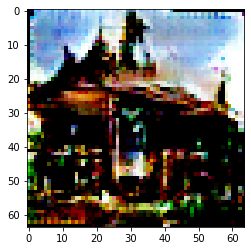

In [191]:
plt.imshow(one_img)

### 4.2 More

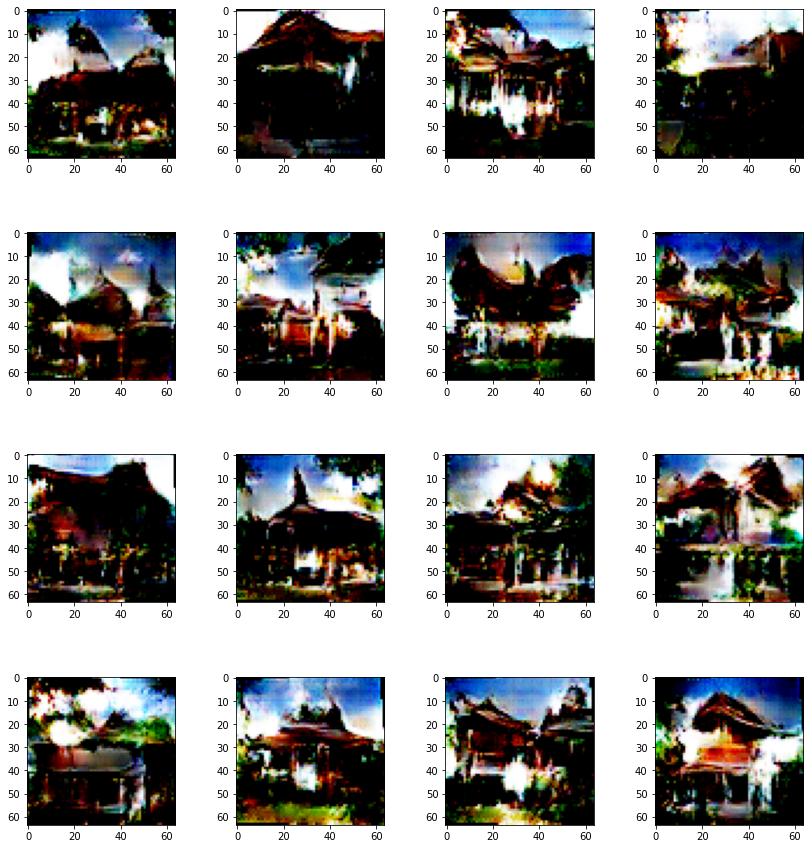

In [196]:
fig, ax = plt.subplots(nrows=4, ncols=4)
fig.set_size_inches(15, 15, forward=True)
for row in ax:
    for col in row:
        col.imshow(tensor_to_img(generate_noise(100), model))

fig.subplots_adjust(wspace=0, hspace=0.5)
plt.show()

### 4.2 Generate 100 images and save

In [601]:
def generate_number(no, model):
    count=1
    for i in range(no):
        # Generate noise
        test_noise = torch.randn(1,100,1,1).to(device)
        
        # Feed into model and reshape to (3, H, W)
        test_img = model(test_noise).squeeze(0).permute(1,2,0).detach().cpu().numpy()
        
        # Convert to 0-255
        test_img = img_as_ubyte(test_img)
        
        # Convert to RGB (for 1 channel image only)
        # test_img = cv2.cvtColor(test_img, cv2.COLOR_GRAY2RGB)
        
        if "gen_img" not in os.listdir('./'):
            os.mkdir('gen_img')
            os.mkdir('gen_img/'+PROJECT_PATH)
        file_name = './gen_img/'+PROJECT_PATH+'/img'+str(count)+'.png'
        plt.imsave(file_name, test_img)
        count+=1

In [602]:
generate_number(100, model)

# 5. Loss

In [236]:
plot_discriminator_loss = [i.detach().cpu().numpy() for _, i in enumerate(log_loss_disc)]

### 5.1 Discriminator

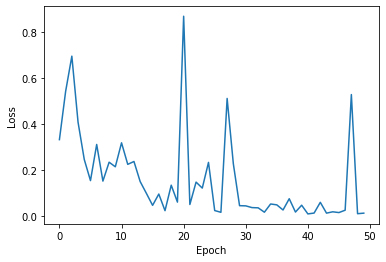

In [237]:
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(plot_discriminator_loss)

### 5.2 Generator

In [ ]:
plot_generator_loss = [i.detach().cpu().numpy() for _, i in enumerate(log_loss_gen)]

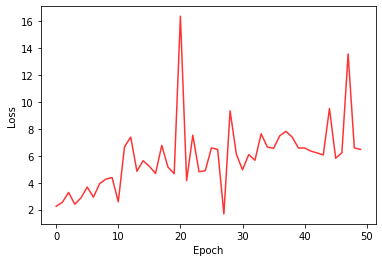

In [239]:
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(plot_generator_loss, alpha=0.8, color='red')

In [240]:
def find_min_loss(li):
    min_loss = max(li)
    position = -1
    for index, i in enumerate(li):
        if i<min_loss:
            min_loss=i
            position=index
    return min, position

In [241]:
find_min_loss(plot_generator_loss)

(<function min>, 27)

In [242]:
plot_generator_loss[27]

array(1.6797681, dtype=float32)